In [24]:
import pathview
import json
from pathsim.blocks import Scope
import matplotlib.pyplot as plt
import pandas as pd

# read graph data from a JSON file
with open("ARC_with_series_GLC.json", "r") as f:
    graph_data = json.load(f)

model, duration = pathview.make_pathsim_model(graph_data)

model.run(1 * 24 * 3600)


20:08:23 - INFO - LOGGING (log: True)
20:08:23 - INFO - BLOCKS (total: 45, dynamic: 10, static: 35, eventful: 1)
20:08:23 - INFO - GRAPH (nodes: 45, edges: 77, alg. depth: 9, loop depth: 0, runtime: 7.319ms)
20:08:23 - INFO - STARTING -> TRANSIENT (Duration: 86400.00s)
20:08:25 - INFO - --------------------   1% | 1.9s<02:34 | 11.1 it/s
20:08:27 - INFO - --------------------   2% | 3.6s<02:35 | 11.0 it/s
20:08:29 - INFO - --------------------   3% | 5.5s<02:54 | 9.6 it/s
20:08:31 - INFO - --------------------   4% | 7.6s<02:59 | 9.4 it/s
20:08:33 - INFO - #-------------------   5% | 9.6s<02:51 | 9.6 it/s
20:08:35 - INFO - #-------------------   6% | 11.5s<02:56 | 9.6 it/s
20:08:37 - INFO - #-------------------   7% | 13.5s<02:44 | 9.8 it/s
20:08:40 - INFO - #-------------------   8% | 15.6s<02:58 | 9.4 it/s
20:08:42 - INFO - #-------------------   9% | 17.6s<02:44 | 9.6 it/s
20:08:44 - INFO - ##------------------  10% | 19.6s<03:10 | 9.1 it/s
20:08:46 - INFO - ##------------------  11%

{'total_steps': 1874,
 'successful_steps': 1874,
 'runtime_ms': 206234.30668700166}

Available scopes:
0: 30
1: 15
2: 49
3: 46
4: 45
5: 16
OFCScope labels: ['blanket (inv)', 'HX (inv)', 'FW (inv)', 'Divertor (inv)', 'T seperation membrane (inv)']
IFCScope labels: ['storage (inv)', 'pump (inv)', 'fuel cleanup (inv)', 'ISS (inv)']
efficiency labels: ['BCR 1 (eff)', 'BCR 2 (eff)', 'BCR 3 (eff)', 'Total efficiency']
liquid concentration labels: ['BCR 1 (c_T_out)', 'c_T_in [mol/m3]', 'BCR 2 (c_T_out)', 'BCR 3 (c_T_out)']
gas concentration labels: ['BCR 1 (y_T2_out)', 'y_T2_in', 'BCR 2 (y_T2_out)', 'BCR 3 (y_T2_out)']


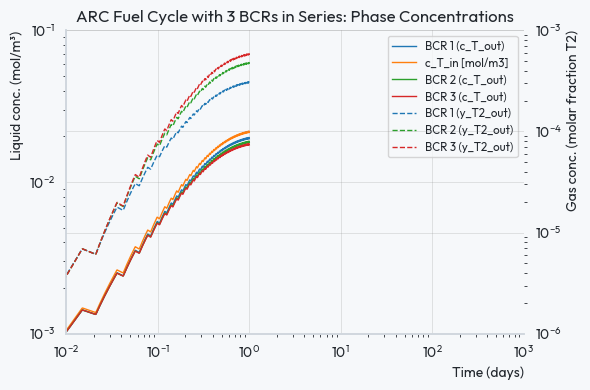

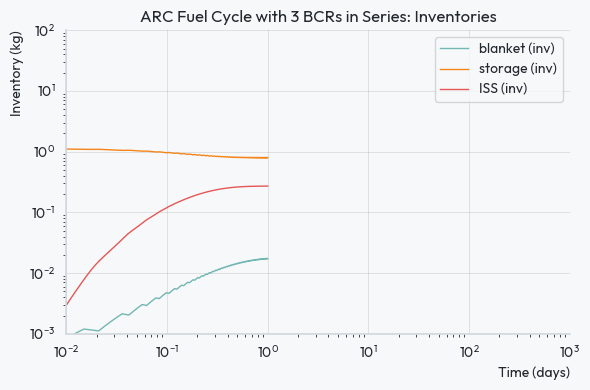

Efficiency scope labels: ['BCR 1 (eff)', 'BCR 2 (eff)', 'BCR 3 (eff)', 'Total efficiency']


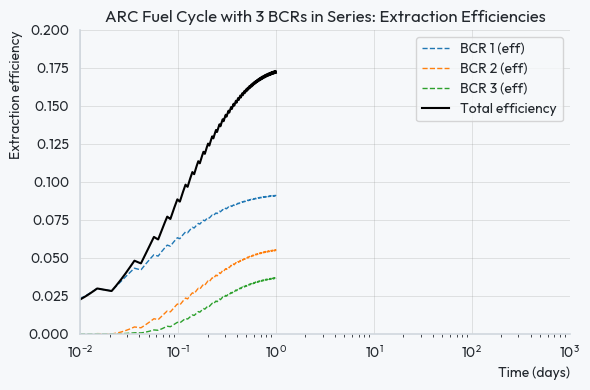

In [31]:
import morethemes as mt
import numpy as np

mt.set_theme("lighter")

scopes = [block for block in model.blocks if isinstance(block, Scope)]

print("Available scopes:")
for i, scope in enumerate(scopes):
    print(f"{i}: {scope.id}")

ifc_scope = scopes[5]
ofc_scope = scopes[1]
fusion_rate_scope = scopes[0]
efficiency_scope = scopes[4]
liquid_concentration_scope = scopes[3]
gas_concentration_scope = scopes[2]

print("OFCScope labels:", ofc_scope.labels)
print("IFCScope labels:", ifc_scope.labels)
print("efficiency labels:", efficiency_scope.labels)
print("liquid concentration labels:", liquid_concentration_scope.labels)
print("gas concentration labels:", gas_concentration_scope.labels)

##### Plot inventories #####
plt.subplots(figsize=(6, 4))
plt.title("ARC Fuel Cycle with 3 BCRs in Series: Inventories")

for scope in [ofc_scope, ifc_scope]:
    sim_time, data = scope.read()
    for p, d in enumerate(data):
        lb = scope.labels[p] if p < len(scope.labels) else f"port {p}"
        if any([kw in lb.lower() for kw in ["blanket", "iss", "storage"]]):
            l, = plt.plot(sim_time / 3600 / 24, d, label=lb, linewidth=1)

    plt.xlabel("Time (days)")
    plt.ylabel("Inventory (kg)")
    plt.yscale("log")
    plt.xscale("log")
plt.ylim(1e-3, 1e2)
plt.xlim(1e-2, 1e3)

plt.legend()
plt.tight_layout()
plt.savefig("arc_series_GLCs_inventories.pdf", dpi=300)
plt.show()
 
##### Plot efficiencies #####
sim_time_eff, data_eff = efficiency_scope.read()
t_days_eff = np.array(sim_time_eff) / 3600.0 / 24.0

plt.subplots(figsize=(6, 4))
plt.title("ARC Fuel Cycle with 3 BCRs in Series: Extraction Efficiencies")

print("Efficiency scope labels:", efficiency_scope.labels)

# classify labels: BCR efficiencies, total, others
bcr_idxs = []
total_idxs = []
for p, lb in enumerate(efficiency_scope.labels):
    l = lb.lower()
    if "bcr" in l:
        bcr_idxs.append(p)
    elif "total" in l:
        total_idxs.append(p)

# colors for the three BCR efficiencies
bcr_colors = ["tab:blue", "tab:orange", "tab:green"]

# plot BCR efficiencies as dashed, each with unique color
for i, p in enumerate(bcr_idxs):
    d = np.array(data_eff[p])
    mask = (t_days_eff > 0) & (d > 0)
    if mask.sum() == 0:
        continue
    col = bcr_colors[i % len(bcr_colors)]
    plt.plot(t_days_eff[mask], d[mask], label=efficiency_scope.labels[p], color=col, linestyle="--", linewidth=1)

# plot total efficiency as a solid line (black by default)
for p in total_idxs:
    d = np.array(data_eff[p])
    mask = (t_days_eff > 0) & (d > 0)
    if mask.sum() == 0:
        continue
    plt.plot(t_days_eff[mask], d[mask], label=efficiency_scope.labels[p], color="black", linestyle="-", linewidth=1.5)


    plt.xlabel("Time (days)")
    plt.ylabel("Extraction efficiency")
    plt.xscale("log")
plt.ylim(0, 0.2)
plt.xlim(1e-2, 1e3)

plt.legend()
plt.tight_layout()
plt.savefig("arc_single_GLC_efficiency.pdf", dpi=300)
plt.show()

##### Plot concentrations #####
sim_time_liq, data_liq = liquid_concentration_scope.read()
sim_time_gas, data_gas = gas_concentration_scope.read()
t_days_liq = np.array(sim_time_liq) / 3600.0 / 24.0
t_days_gas = np.array(sim_time_gas) / 3600.0 / 24.0

fig2, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()
ax1.set_title("ARC Fuel Cycle with 3 BCRs in Series: Phase Concentrations")
ax1.set_xlabel("Time (days)")
ax1.set_xscale("log")

# choose which labels count as liquid / gas (case-insensitive)
liq_keys = ["c_t_in", "c_t_out", "c_t"]
gas_keys = ["y_t2_in", "y_t2_out", "y_t2"]

# collect indices to plot
liq_idxs = [p for p, lb in enumerate(liquid_concentration_scope.labels)
            if any(k in lb.lower() for k in liq_keys)]
gas_idxs = [p for p, lb in enumerate(gas_concentration_scope.labels)
            if any(k in lb.lower() for k in gas_keys)]

# fallback: if none matched, plot all ports
if not liq_idxs:
    liq_idxs = list(range(len(data_liq)))
if not gas_idxs:
    gas_idxs = list(range(len(data_gas)))

# colors for the inlet concentration & three BCRs
bcr_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

# Plot liquid (solid lines)
for i, p in enumerate(liq_idxs):
    d = np.array(data_liq[p])
    lb = liquid_concentration_scope.labels[p] if p < len(liquid_concentration_scope.labels) else f"port {p}"
    mask = (t_days_liq > 0) & (d > 0)
    if mask.sum() == 0:
        continue
    ax1.plot(t_days_liq[mask], d[mask],
             label=lb,
             color=bcr_colors[i % len(bcr_colors)],
             linestyle="-",
             linewidth=1)

# Plot gas (dashed lines)
for i, p in enumerate(gas_idxs):
    d = np.array(data_gas[p])
    lb = gas_concentration_scope.labels[p] if p < len(gas_concentration_scope.labels) else f"port {p}"
    mask = (t_days_gas > 0) & (d > 0)
    if mask.sum() == 0:
        continue
    ax2.plot(t_days_gas[mask], d[mask],
             label=lb,
             color=bcr_colors[i % len(bcr_colors)],
             linestyle="--",
             linewidth=1)

ax1.set_ylabel("Liquid conc. (mol/m³)")
ax2.set_ylabel("Gas conc. (molar fraction T2)")
ax1.set_yscale("log")
ax2.set_yscale("log")

# combined legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
if handles1 or handles2:
    ax1.legend(handles1 + handles2, labels1 + labels2, loc="best", fontsize="small")

ax1.set_xlim(1e-2, 1e3)
ax1.set_ylim(1e-3, 1e-1)   # liquid
ax2.set_ylim(1e-6, 1e-3)   # gas

fig2.tight_layout()
fig2.savefig("arc_single_GLC_concentrations.pdf", dpi=300)
fig2.show()